In [287]:
import opendatasets as od
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from catboost import CatBoostRegressor
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

import warnings

warnings.filterwarnings("ignore")

if not os.path.exists("../datasets"):
    os.makedirs("../datasets")

PROJECT_URL = "https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset"
PROJECT_NAME = PROJECT_URL.split("/")[-1]
DATA_PATH = os.path.join("../datasets", PROJECT_NAME)
od.download(PROJECT_URL, "../datasets")

Skipping, found downloaded files in "../datasets/usa-real-estate-dataset" (use force=True to force download)


#### Functions

In [288]:
# Removing outliers
def find_outliers(col):

    Q1, Q3 = col.describe()[["25%", "75%"]]
    IQR = Q3 - Q1
    high = Q3 + IQR * 1.5
    low = Q1 - IQR * 1.5
    is_outliar = col.map(lambda x: x > high or x < low)
    print(f"Found {(is_outliar).sum()} outliers")

    return is_outliar

def cv_calc(model, X, y, cv=5):
    
    t1 = time.time()
    scores = np.sqrt(-cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring="neg_mean_squared_error"))
    t2 = time.time() - t1
    calc_time = round(t2,2)
    scores = round(np.mean(scores),5)

    print(f"Cross validation Mean squared error: {scores}\nTime: {calc_time}s")

    return calc_time, scores

def custom_fillnas(df):
    df_imp = df.dropna(subset=["city", "state", "price"])

    df_imp.loc[:, "bed"] = df_imp["bed"].fillna(df_imp.groupby("city").bed.transform("median").transform("round"))
    df_imp.loc[:, "bath"] = df_imp["bath"].fillna(df_imp.groupby("city").bath.transform("median").transform("round"))
    df_imp.loc[:, "acre_lot"] = df_imp["acre_lot"].fillna(df_imp.groupby("city").acre_lot.transform("median"))
    df_imp.loc[:, "house_size"] = df_imp["house_size"].fillna(df_imp.groupby("city").house_size.transform("median"))

    df_imp = df_imp.dropna()
    X_imp = df_imp.drop(columns=["price"])
    y_imp = df_imp["price"].copy()

    return X_imp, y_imp

### EDA

In [289]:
df = pd.read_csv(os.path.join(DATA_PATH, "realtor-data.csv"))
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          100000 non-null  object 
 1   bed             75050 non-null   float64
 2   bath            75112 non-null   float64
 3   acre_lot        85987 non-null   float64
 4   city            99948 non-null   object 
 5   state           100000 non-null  object 
 6   zip_code        99805 non-null   float64
 7   house_size      75082 non-null   float64
 8   prev_sold_date  28745 non-null   object 
 9   price           100000 non-null  float64
dtypes: float64(6), object(4)
memory usage: 7.6+ MB


In [291]:
df.describe()

,bed,bath,acre_lot,zip_code,house_size,price
count,75050.000000,75112.000000,85987.000000,99805.000000,7.508200e+04,1.000000e+05
mean,3.701013,2.494595,13.613473,2132.003467,2.180082e+03,4.383656e+05
std,2.091372,1.573324,840.143878,2455.654774,5.625349e+03,1.015773e+06
min,1.000000,1.000000,0.000000,601.000000,1.000000e+02,4.450000e+02
25%,3.000000,2.000000,0.190000,971.000000,1.200000e+03,1.250000e+05
50%,3.000000,2.000000,0.510000,1225.000000,1.728000e+03,2.650000e+05
75%,4.000000,3.000000,2.000000,1611.000000,2.582000e+03,4.749000e+05
max,86.000000,56.000000,100000.000000,99999.000000,1.450112e+06,6.000000e+07


In [292]:
df.describe(include='O').T

,count,unique,top,freq
status,100000,2,for_sale,99819
city,99948,525,San Juan,4788
state,100000,12,Massachusetts,52694
prev_sold_date,28745,3604,2019-10-01,83


In [293]:
df.isnull().sum()

status                0
bed               24950
bath              24888
acre_lot          14013
city                 52
state                 0
zip_code            195
house_size        24918
prev_sold_date    71255
price                 0
dtype: int64

In [294]:
# Status seems irrelevant , prev_sold_date 71% missing values
df.drop(columns=["status", "prev_sold_date", "zip_code"], inplace=True)

From the output of <b>.describe()</b> we see that we have outliars. I will remove them using the rule anything outside the interval <b>[Q1 - interquartile range * 1.5,  Q3 + interquartile range * 1.5]</b> is an outliar. Running this in an iterative manner for every column gives better performance compared to precalculating them for each column before removing the outliars.

In [295]:
print(df.shape)
for c in ["bed", "bath", "acre_lot", "house_size", "price"]:
    print(f"checking {c}")
    
    df = df.loc[~find_outliers(df[c]), :]
print(df.shape)

(100000, 7)
checking bed
Found 10589 outliers
checking bath
Found 2131 outliers
checking acre_lot
Found 11063 outliers
checking house_size
Found 2232 outliers
checking price
Found 3358 outliers
(70627, 7)


In [296]:
print(df.state.value_counts())

state
Massachusetts     36051
Puerto Rico       18325
Connecticut        9623
Virgin Islands     1824
Rhode Island       1766
New Hampshire      1532
Vermont             761
New York            700
South Carolina       24
Tennessee            16
Virginia              3
New Jersey            2
Name: count, dtype: int64


In [297]:
# Drop states with low sample size
print(df.shape)
df = df.loc[~df.state.isin(["South Carolina", "Tennessee", "Virginia", "New Jersey"]), :]
print(df.shape)

(70627, 7)
(70582, 7)


In [298]:
df.city.value_counts()

city
San Juan            2949
Worcester           2169
Springfield         2044
Bayamon             1591
Pittsfield          1552
                    ... 
Stanford               1
Malden On Hudson       1
Madison                1
Johnsonville           1
East Greenbush         1
Name: count, Length: 493, dtype: int64

In [299]:
# Drop cities with low sample size
tmp = df.city.value_counts().reset_index()
city_count_map = dict(zip(tmp["city"], tmp["count"]))
df = df.assign(city_count = lambda x: x["city"].map(city_count_map))

print(df.shape)
df = df.loc[df["city_count"] >= 90, :]
print(df.shape)
df.drop(columns=["city_count"], inplace=True)

(70582, 8)
(61202, 8)


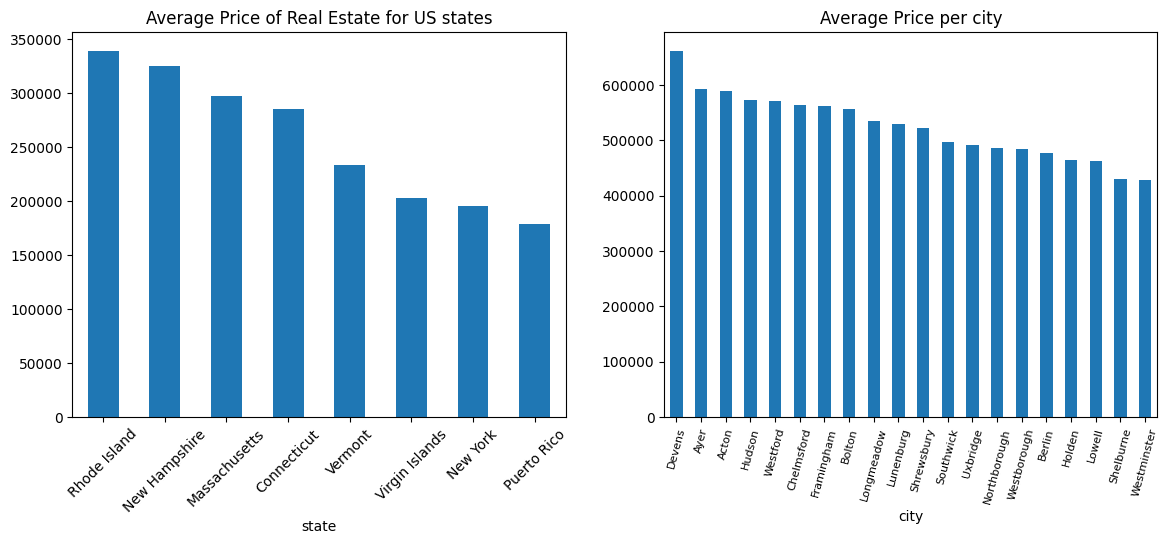

In [300]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
df.groupby('state').price.mean().sort_values(ascending=False).plot.bar(ax=ax1)
plt.title('Average Price of Real Estate for US states')
plt.xticks(rotation=45)
ax2 = plt.subplot(1,2,2)
df.groupby('city').price.mean().sort_values(ascending=False).head(20).plot.bar(ax=ax2)
ax2.xaxis.set_tick_params(labelsize=8)
plt.title('Average Price per city')
plt.xticks(rotation=75)
plt.show()

#### Plots after cleaning

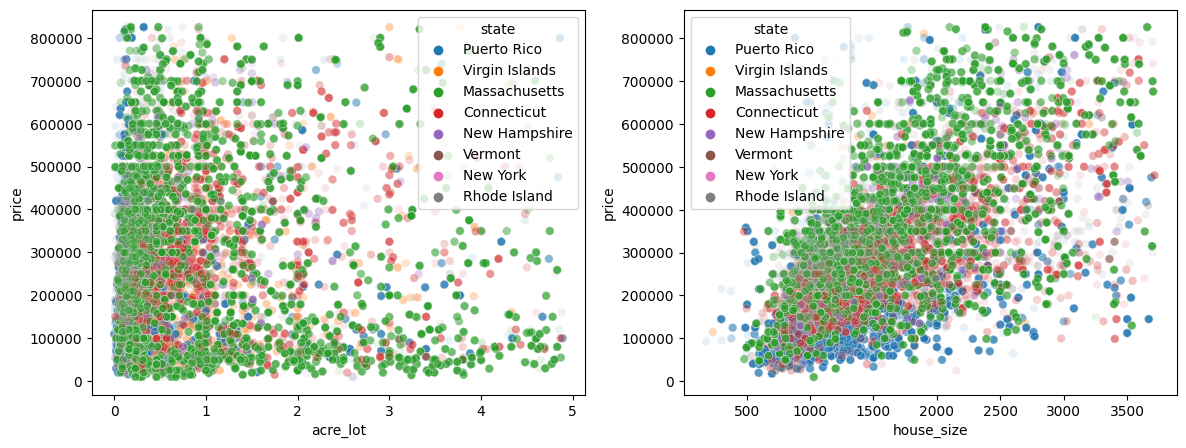

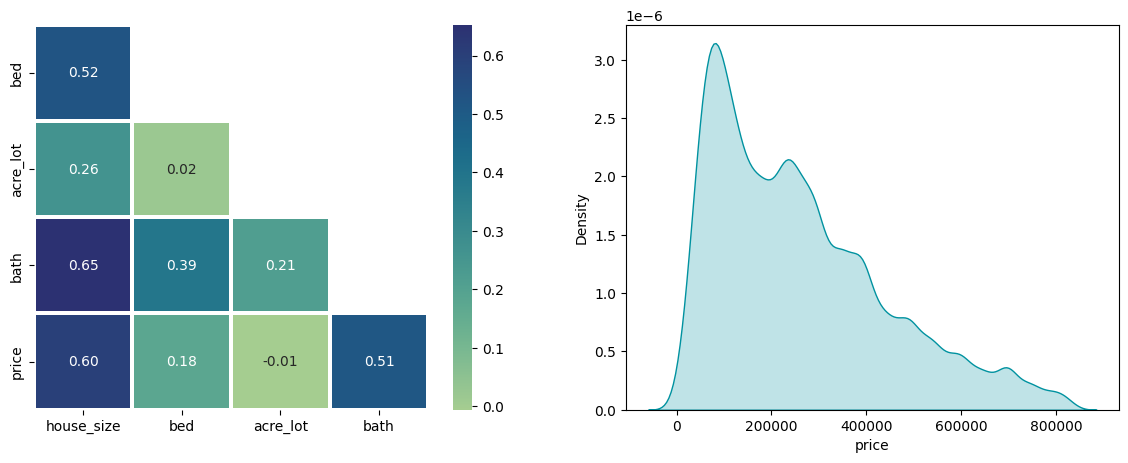

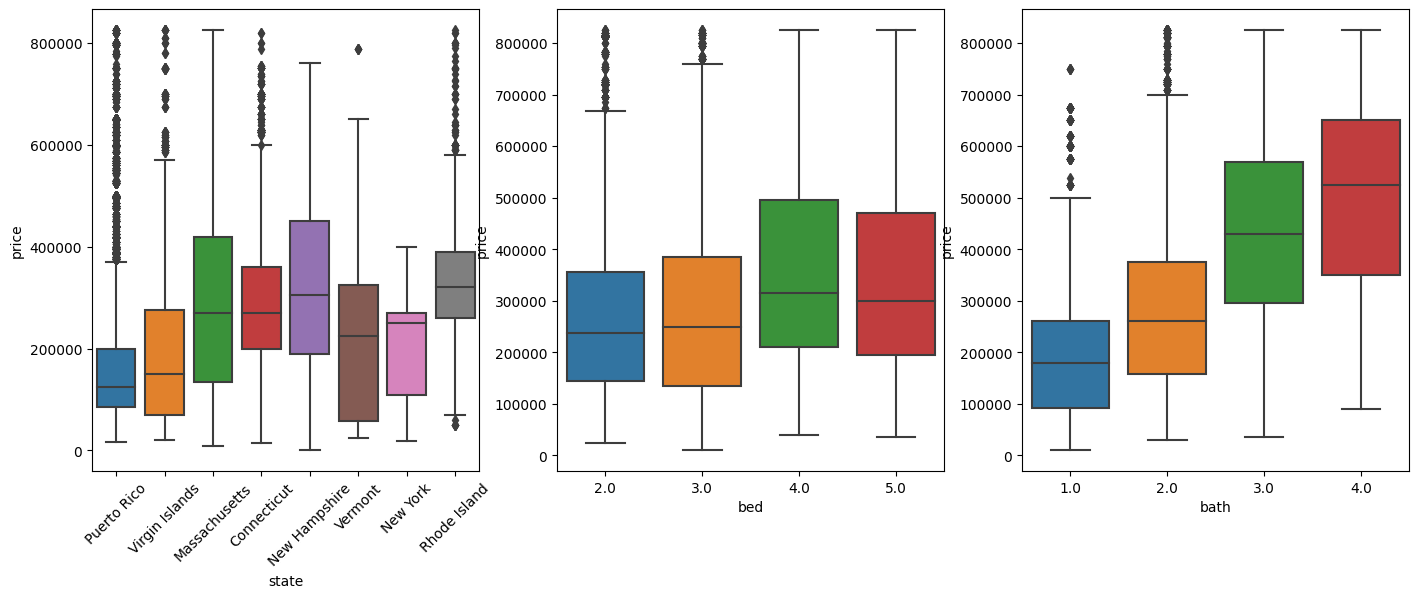

In [301]:
# Scatter plots
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(df, x="acre_lot", y="price", hue="state", alpha=0.1, ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.scatterplot(df, x="house_size", y="price", hue="state", alpha=0.1, ax=ax2)
plt.show()

# Heat map with price distribution
plt.figure(figsize=(14,5))
corr_mat = df[["house_size", "bed", "acre_lot", "bath", "price"]].corr()
mask = np.triu(np.ones_like(corr_mat)).astype(bool)
mask = mask[1:, :-1]
corr_mat = corr_mat.iloc[1:,:-1]
ax1 = plt.subplot(1,2,1)
sns.heatmap(corr_mat, annot=True, linewidth=1.5, fmt=".2f", cmap="crest", mask=mask, ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.kdeplot(df["price"], fill=True, color="#0092A0", ax=ax2)
plt.show()

# Box plots
plt.figure(figsize=(17,6))
ax1 = plt.subplot(1,3,1)
sns.boxplot(df, x="state", y="price", ax=ax1)
plt.xticks(rotation=45)
ax2 = plt.subplot(1,3,2)
sns.boxplot(df, x="bed", y="price", ax=ax2)
ax3 = plt.subplot(1,3,3)
sns.boxplot(df, x="bath", y="price", ax=ax3)
plt.show()

Looks like number of bathrooms and house size have a correlation with the price which is an expected result and should have strong predictive power.
Acre_lot - Price scatter plot doesn't reveal any obvious pattern. There is no obvious pattern for acre_lot. Also states are having different price distributions which is something I might be able to use.

## Models

In [302]:
metrics = {}


df_train, df_test = train_test_split(df, test_size=0.2, random_state=47, stratify=df["city"].tolist())

### Dropping all NaN values

In [303]:
# Drop rows that have at least one null value
print("Dataframe size before dropna:", df.shape)
df_train_dropna_all = df.dropna()
print("Dataframe size after dropna:", df_train_dropna_all.shape)

Dataframe size before dropna: (61202, 7)
Dataframe size after dropna: (37304, 7)


In [304]:
df_train_dropna_all.shape

(37304, 7)

In [305]:
# Split features and labels
X_dropna_all = df_train_dropna_all.drop(columns=["price"])
y_dropna_all = df_train_dropna_all["price"].copy()

<h5>Only with numerical columns</h5>

In [306]:
X_dropna_all_num = X_dropna_all.select_dtypes(exclude=["object"])

RandomForest

In [307]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_dropna_all_num, y_dropna_all)
metrics["forest_dropna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 47546.56714
Time: 1.12s


Ridge regression

In [308]:
# Ridge regression
l2_reg = Ridge(random_state=47)
calc_time, score = cv_calc(l2_reg, X_dropna_all_num, y_dropna_all)
metrics["ridge_dropna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 137828.07293
Time: 0.12s


CatBoost

In [309]:
# Catboost
cat = CatBoostRegressor(random_state=47, verbose=0)
calc_time, score = cv_calc(cat, X_dropna_all_num, y_dropna_all)
metrics["catboost_dropna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 98924.23563
Time: 7.65s


<h5>Adding categorical columns</h5>

RandomForest

In [175]:
X_dropna_all_oh = pd.get_dummies(X_dropna_all)

forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_dropna_all_oh, y_dropna_all)
metrics["forest_dropna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 36417.15031
Time: 10.61s


CatBoost

In [176]:
cat = CatBoostRegressor(random_state=47, verbose=0)
calc_time, score = cv_calc(cat, X_dropna_all_oh, y_dropna_all)
metrics["catboost_dropna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 61694.7386
Time: 11.33s


<h3> Fillnas </h3>

In [310]:
# fillnas
X_imp, y_imp = custom_fillnas(df_train)

<h5>Only numerical columns</h5>

Random forest

In [178]:
X_imp_num = X_imp.select_dtypes(exclude=["object"])

In [179]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_imp_num, y_imp)
metrics["forest_fillna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 33680.5647
Time: 2.04s


CatBoost

In [180]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_imp_num, y_imp)
metrics["catboost_fillna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 81662.73504
Time: 9.67s


<h4>Fillnas one hot for categorical</h4>

In [181]:
X_imp_oh = pd.get_dummies(X_imp)

RandomForest

In [182]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_imp_oh, y_imp)
metrics["forest_fillna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 30784.8598
Time: 25.46s


CatBoost

In [183]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_imp_oh, y_imp)
metrics["catboost_fillna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 74417.17778
Time: 13.81s


<b>Feature scaling</b>

In [311]:
scaler = StandardScaler()
X_imp_num = X_imp.select_dtypes(exclude=["object"])
X_imp_obj = X_imp.select_dtypes(exclude=["float64"])
X_temp = scaler.fit_transform(X_imp_num)
X_imp_num = pd.DataFrame(X_temp, columns=X_imp_num.columns.tolist())
X_imp_scaled = X_imp_num.join(X_imp_obj) 
X_imp_scaled_oh = pd.get_dummies(X_imp_scaled)

RandomForest

In [312]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_imp_scaled_oh, y_imp)
metrics["forest_fillna_scaled"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 44311.81779
Time: 21.35s


CatBoost

In [186]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_imp_scaled_oh, y_imp)
metrics["catboost_fillna_scaled"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 85867.59729
Time: 13.62s


<h4>Feature Engineering</h4>

Adding clusters

In [187]:
def add_clusters(X, y):
    km = KMeans(n_clusters=4, random_state=47)
    tmp = X.join(y).loc[: , ["bed", "bath", "house_size"]]
    tmp["cluster"] = km.fit_predict(tmp)
    tmp.loc[:, "cluster"] = tmp["cluster"].astype("category")
    X["cluster"] = tmp["cluster"]

    return X

In [188]:
X_imp_cls = add_clusters(X_imp, y_imp)
X_imp_cls_oh = pd.get_dummies(X_imp_cls)

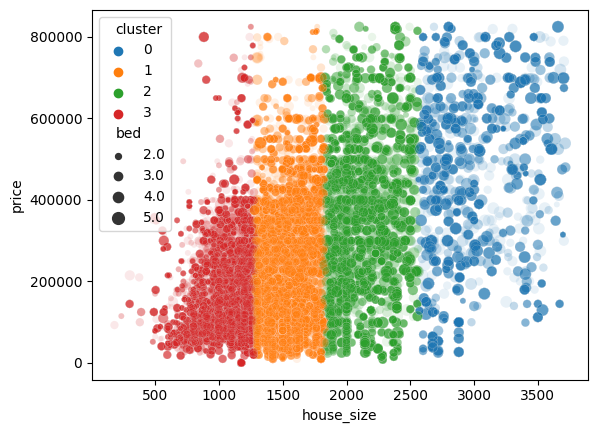

In [189]:
sns.scatterplot(x="house_size", y="price", hue="cluster", alpha=0.1, size="bed", data=X_imp_cls.join(y_imp))
plt.show()

In [190]:
forest = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest, X_imp_cls_oh, y_imp)
metrics["forest_cluster_oh"] = {"time": calc_time, "score": score}

Cross validation Mean squared error: 30745.23171
Time: 26.2s


In [313]:
num_cols = list(X_imp.select_dtypes(exclude=["object"]))
cat_cols = list(X_imp.select_dtypes(exclude=["float64"]))

poly_transformer = ColumnTransformer([
    ("num", PolynomialFeatures(degree=2), num_cols),
    ("cat", OneHotEncoder(), cat_cols)
])

X_imp_augm_oh = poly_transformer.fit_transform(X_imp)

In [314]:
forest = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest, X_imp_augm_oh, y_imp)
metrics["forest_augm_oh"] = {"time": calc_time, "score": score}

Cross validation Mean squared error: 29896.27291
Time: 56.65s


In [196]:
pd.DataFrame(metrics).T.sort_values(by="score", ascending=True)

,time,score
forest_augm_oh,111.03,30151.71127
forest_cluster_oh,26.20,30745.23171
forest_fillna_oh,25.46,30784.85980
forest_fillna_num,2.04,33680.56470
forest_dropna_oh,10.61,36417.15031
forest_fillna_scaled,25.09,37102.46364
forest_dropna_num,1.48,47177.98055
catboost_dropna_oh,11.33,61694.73860
catboost_fillna_oh,13.81,74417.17778
catboost_dropna_num,8.15,80400.27827


<b>Observations</b>
<ul>
    <li>Dropping outliars improved performance</li>
    <li>Dropping cities with low sample size improved performance and speed up training</li>
    <li>Adding clusters helped to improve performance a little although it looks like it is in the margin of error</li>
    <li>Feature engineering added some small performance gain</li>
    <li>Best performing model in all cases was the random forest</li>
</ul>

### Model optimization

In [54]:
# Running model optimization only on numerical columns to speed up process
search_space = [
    Integer(100, 1500, name="n_estimators"),
    Integer(5, 50, name="max_depth"),
    Integer(2, 100, name='min_samples_split'),
    Integer(1, 100, name='min_samples_leaf')
    ]

model = RandomForestRegressor(n_jobs=-1, random_state=47)

@use_named_args(search_space)
def evaluate_model(**params):
    model.set_params(**params)
    return  np.mean(np.sqrt(-cross_val_score(model, X_imp_num, y_imp, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')))

# perform optimization
t1 = time.time()
forest_gp = gp_minimize(evaluate_model, search_space, n_calls=50, verbose=False, n_jobs=-1, random_state=47)
opt_time = time.time() - t1
# summarizing finding:
print("Total optimization time: %.2f  Best Accuracy: %.3f" % (opt_time, forest_gp.fun))
print(f"Best parameters: n_estimators={forest_gp.x[0]}, max_depth={forest_gp.x[1]}, min_samples_split={forest_gp.x[2]}, min_samples_leaf={forest_gp.x[3]}")

Best Accuracy: 49753.358
Best parameters: n_estimators=1500, max_depth=50, min_samples_split=2, min_samples_leaf=1


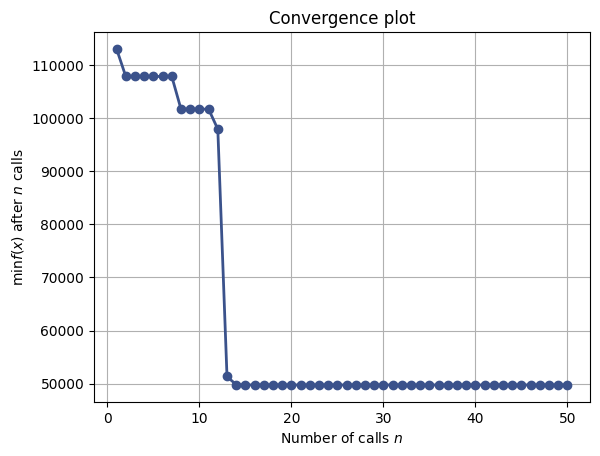

In [58]:
plot_convergence(forest_gp)
plt.show()

In [62]:
forest_opt = RandomForestRegressor(
    n_estimators=forest_gp.x[0], 
    max_depth=forest_gp.x[1], 
    min_samples_split=forest_gp.x[2], 
    min_samples_leaf=forest_gp.x[3],
    n_jobs=-1, random_state=47
    )

calc_time, score = cv_calc(forest_opt, X_imp_oh, y_imp)
metrics["forest_opt_fillna_oh"] = {"time": calc_time, "score": score}

Cross validation Mean squared error: 38579.49615
Time: 952.12s


In [65]:
pd.DataFrame(metrics).T.sort_values(by="score", ascending=True)

,time,score
forest_fillna_oh,59.63,37585.23550
forest_cluster,64.34,37608.51323
forest_opt_fillna_oh,952.12,38579.49615
forest_dropna_oh,24.51,45710.17529
forest_fillna_num,1.90,49837.87286
forest_fillna_scaled,40.41,54710.72798
forest_dropna_num,1.97,60811.62579
catboost_dropna_oh,17.97,73307.76373
catboost_fillna_oh,20.04,86332.55837
catboost_dropna_num,9.01,105767.40433


<h3>Model explainability</h3> (work in progress)

In [201]:
# work in progress
import eli5
from eli5.sklearn import PermutationImportance

X_test_imp, y_test_imp = custom_fillnas(df_test)
X_test_imp_oh = poly_transformer.fit_transform(X_test_imp)

final_model = RandomForestRegressor(n_jobs=-1, random_state=47).fit(X_imp_oh, y_imp)

perm = PermutationImportance(final_model, random_state=47).fit(X_test_imp_oh, y_test_imp)
eli5.show_weights(perm, feature_names=X_imp_oh.columns.tolist())


ValueError: A given column is not a column of the dataframe

In [ ]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_dropna_all_num, y_dropna_all)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_dropna_all_num.columns)
mi_scores.sort_values(ascending=False)

house_size    4.188811
acre_lot      2.440356
bath          0.399550
bed           0.305886
Name: MI Scores, dtype: float64